### Task4: Ансамбли

#### Импорт необходимых библиотек

In [148]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

#### Набор данных

Был выбран датасет с информацией об автомобилях, которые продавались в Польше. Набор содержит данные о марке, модели, поколении, годе выпуска, пробеге, местоположении и цене машины, а также о типе и об объеме двигателя.

In [149]:
df = pd.read_csv("Car_Prices_Poland_Kaggle.csv")

df.head()

,Unnamed: 0,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
0,0,opel,combo,gen-d-2011,2015,139568,1248,Diesel,Janki,Mazowieckie,35900
1,1,opel,combo,gen-d-2011,2018,31991,1499,Diesel,Katowice,Śląskie,78501
2,2,opel,combo,gen-d-2011,2015,278437,1598,Diesel,Brzeg,Opolskie,27000
3,3,opel,combo,gen-d-2011,2016,47600,1248,Diesel,Korfantów,Opolskie,30800
4,4,opel,combo,gen-d-2011,2014,103000,1400,CNG,Tarnowskie Góry,Śląskie,35900


In [150]:
df.shape

(117927, 11)

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117927 entries, 0 to 117926
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Unnamed: 0       117927 non-null  int64 
 1   mark             117927 non-null  object
 2   model            117927 non-null  object
 3   generation_name  87842 non-null   object
 4   year             117927 non-null  int64 
 5   mileage          117927 non-null  int64 
 6   vol_engine       117927 non-null  int64 
 7   fuel             117927 non-null  object
 8   city             117927 non-null  object
 9   province         117927 non-null  object
 10  price            117927 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 9.9+ MB


In [152]:
df.isna().sum()

Unnamed: 0             0
mark                   0
model                  0
generation_name    30085
year                   0
mileage                0
vol_engine             0
fuel                   0
city                   0
province               0
price                  0
dtype: int64

В датасете отсутствуют данные об имени поколения (generation_name) у 30085 автомобилей. Удалим этот столбец, а также столбец "Unnamed: 0", так как в нем содержится информация только о номере строки.

In [153]:
df.drop(columns=["generation_name", "Unnamed: 0"], inplace=True)

In [154]:
df.describe().round(3)

,year,mileage,vol_engine,price
count,117927.000,117927.000,117927.000,117927.000
mean,2012.925,140976.786,1812.058,70299.885
std,5.690,92369.357,643.613,84824.578
min,1945.000,0.000,0.000,500.000
25%,2009.000,67000.000,1461.000,21000.000
50%,2013.000,146269.000,1796.000,41900.000
75%,2018.000,203000.000,1995.000,83600.000
max,2022.000,2800000.000,7600.000,2399900.000


Необходимо проверить данные на дубликаты, в случае их наличия удалим лишние строки.

In [155]:
old_len = len(df)
df.drop_duplicates(inplace=True)
len_dropped_rows = old_len - len(df)
if len_dropped_rows > 0:
    print(f'Дубликатов удалено: {len_dropped_rows}')
else:
    print("Дубликаты отсутствуют")

Дубликатов удалено: 6761


#### Распределение данных

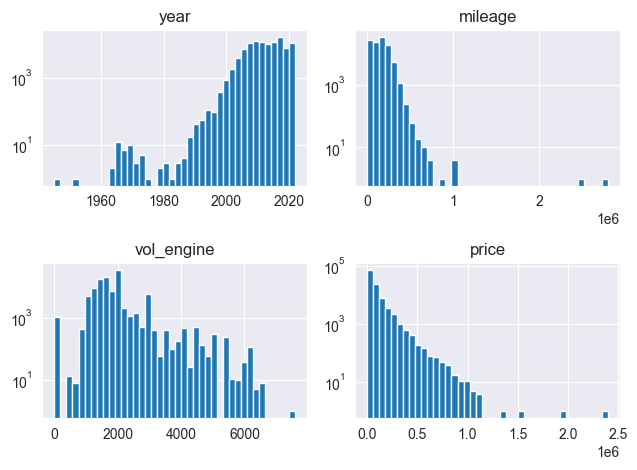

In [156]:
df.hist(column=["year", "mileage", "vol_engine", "price"], bins=40, log=True)
plt.tight_layout()

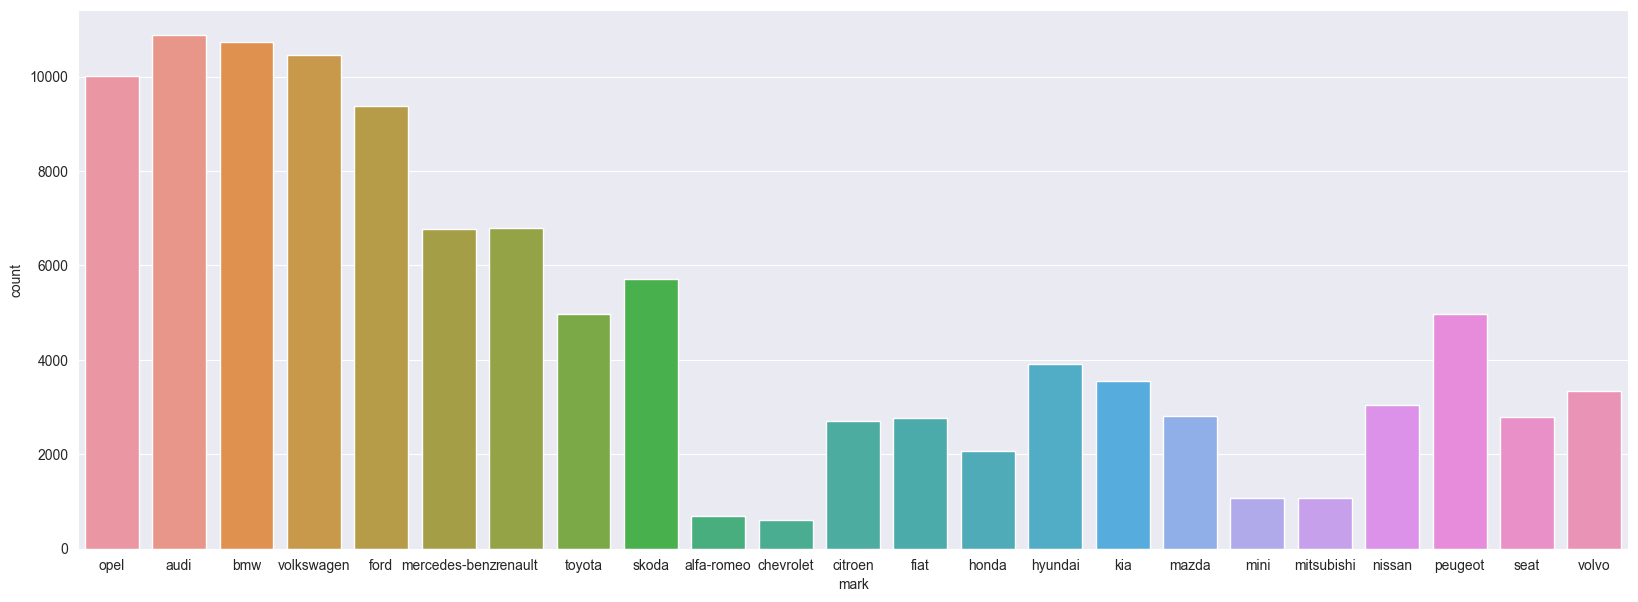

In [157]:
plt.figure(figsize=(20, 7))
sns.countplot(x=df["mark"])
plt.show()

По графику зависимости количества машин от марки можно сделать вывод, что наиболее популярными являются opel, audi, bmw, volkswagen и ford, каждая из перечисленных моделей занимает порядка 10% от общего количества данных.

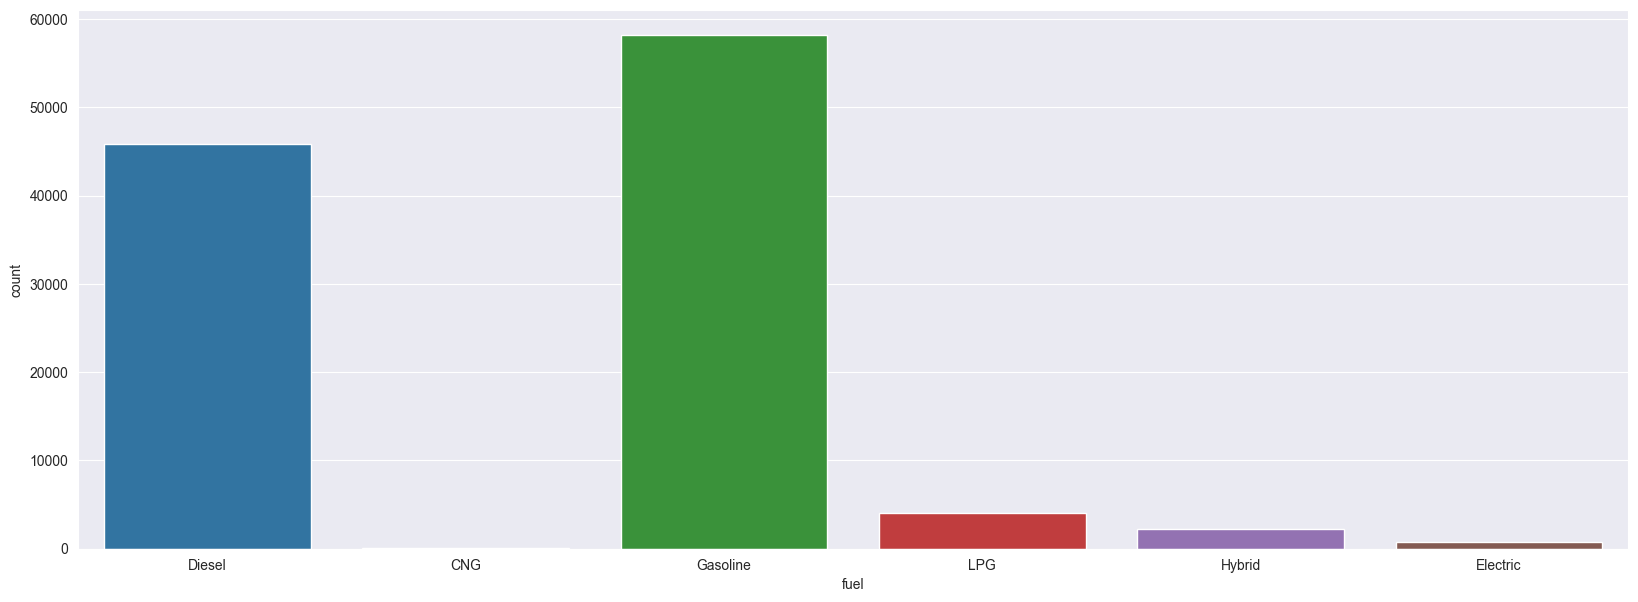

In [158]:
plt.figure(figsize=(20, 7))
sns.countplot(x=df["fuel"])
plt.show()

Наибольшее количество машин из датасета работает на бензине и дизеле.

#### Корреляция

Для анализа зависимостей необходимо преобразовать строковые атрибуты в числа.

In [159]:
LE = LabelEncoder()
df["mark"] = LE.fit_transform(df["mark"])
df["model"] = LE.fit_transform(df["model"])
df["fuel"] = LE.fit_transform(df["fuel"])
df["city"] = LE.fit_transform(df["city"])
df["province"] = LE.fit_transform(df["province"])

print(df.head())

   mark  model  year  mileage  vol_engine  fuel  city  province  price
0    15     89  2015   139568        1248     1  1161         6  35900
1    15     89  2018    31991        1499     1  1365        21  78501
2    15     89  2015   278437        1598     1   300        11  27000
3    15     89  2016    47600        1248     1  1510        11  30800
4    15     89  2014   103000        1400     0  3606        21  35900


По таблице представленной ниже можно увидеть, что на цену автомобиля наиболее сильно влияют год выпуска, пробег и объем двигателя. При увеличении года выпуска и объема двигателя цена возрастает, а при увеличении пробега цена падает, исходя из знака коэффициента.

<Axes: >

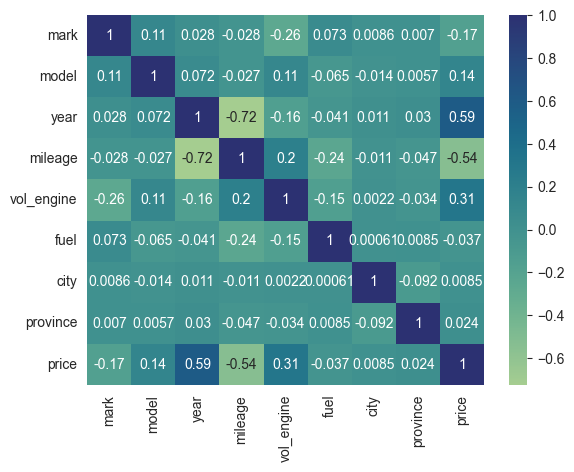

In [160]:
sns.heatmap(df.corr(), annot=True, cmap="crest")

#### Ансамбли

In [161]:
import numpy as np
import numpy.typing as npt
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.validation import check_X_y, check_scalar, check_random_state, check_is_fitted, check_array
from sklearn.utils.estimator_checks import check_estimator

### Собственные реализации алгоритмов:

#### Bagging

In [162]:
class SimpleBaggingRegressor(BaseEstimator, RegressorMixin):

    def __init__(self, estimator=None, n_estimators=10, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.random_state = random_state

    def set_random_states(self, estimator):
        random_states = {}
        for param_name in estimator.get_params(deep=True):
            if param_name == "random_state" or param_name.endswith("__random_state"):
                random_states[param_name] = self.random_state_.tomaxint()
        estimator.set_params(**random_states)

    def set_estimator(self):
        self.estimator_ = self.estimator if self.estimator is not None else DecisionTreeRegressor()

    def bootstrap_sample(self, X: npt.NDArray, y: npt.NDArray) -> tuple[npt.NDArray, npt.NDArray]:
        bootstrap_indices = self.random_state_.choice(len(y), size=len(y))
        data_bootstrap = X[bootstrap_indices]
        target_bootstrap = y[bootstrap_indices]
        return data_bootstrap, target_bootstrap

    def fit(self, X: npt.ArrayLike, y: npt.ArrayLike) -> "SimpleBaggingRegressor":
        self.n_estimators = check_scalar(self.n_estimators, "n_estimators", int, min_val=1)
        self.random_state_ = check_random_state(self.random_state)
        X, y = check_X_y(X, y)
        self.set_estimator()
        self.estimators_ = []
        for i in range(self.n_estimators):
            estimator = clone(self.estimator_)
            self.set_random_states(estimator)
            X_sample, y_sample = self.bootstrap_sample(X, y)
            estimator.fit(X_sample, y_sample)
            self.estimators_.append(estimator)
        self.n_features_in_ = X.shape[1]
        return self

    def predict(self, X: npt.ArrayLike) -> npt.NDArray:
        check_is_fitted(self)
        X = check_array(X)

        predictions = [estimator.predict(X) for estimator in self.estimators_]
        aggregated = np.mean(predictions, axis=0)
        return aggregated


#### AdaBoost

In [163]:
class SimpleAdaBoostRegressor(BaseEstimator, RegressorMixin):

    def __init__(self, estimator=None, n_estimators=50, *, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.random_state = random_state

    def _set_estimator(self):
        self.estimator_ = self.estimator if self.estimator is not None else DecisionTreeRegressor(max_depth=3)

    def fit(self, X: npt.ArrayLike, y: npt.ArrayLike) -> "SimpleAdaBoostRegressor":
        self.n_estimators = check_scalar(self.n_estimators, "n_estimators", int, min_val=1)
        self.random_state_ = check_random_state(self.random_state)
        X, y = check_X_y(X, y, y_numeric=True)
        self._set_estimator()
        self.estimators_ = []
        self.estimator_weights_ = []
        weight = np.full(len(y), fill_value=(1 / len(y)))
        for _ in range(self.n_estimators):
            estimator = clone(self.estimator_)
            predicted = estimator.fit(X, y, sample_weight=weight).predict(X)
            errors = np.abs(predicted - y)
            max_error = np.max(errors)
            if max_error > 0:
                errors /= max_error
            avg_error = np.sum(errors * weight)

            if avg_error == 0:
                self.estimators_.append(estimator)
                self.estimator_weights_.append(1.0)
                break
            elif avg_error >= 0.5:
                if len(self.estimators_) == 0:
                    self.estimators_.append(estimator)
                    self.estimator_weights_.append(1.0)
                break
            beta = avg_error / (1 - avg_error)
            weight *= np.power(beta, 1 - errors)
            weight /= np.sum(weight)
            self.estimators_.append(estimator)
            self.estimator_weights_.append(np.log(1 / beta))
        self.estimator_weights_ = np.array(self.estimator_weights_)

        self.n_features_in_ = X.shape[1]

        return self

    def predict(self, X: npt.ArrayLike) -> npt.NDArray:
        check_is_fitted(self)
        X = check_array(X)

        predictions = np.array([estimator.predict(X) for estimator in self.estimators_]).T

        sorted_prediction = np.argsort(predictions, axis=1)
        sorted_weights = np.cumsum(self.estimator_weights_[sorted_prediction], axis=1)
        is_median_or_above = sorted_weights >= (sorted_weights[0][-1] / 2)
        median_ids = np.argmax(is_median_or_above, axis=1)
        median_ids = sorted_prediction[np.arange(len(X)), median_ids]
        aggregated = predictions[np.arange(len(X)), median_ids]

        return aggregated

Необходимо проверить собственные реализации алгоритмов BaggingRegressor и AdaBoostRegressor на совместимость с sklearn:

In [164]:
check_estimator(SimpleBaggingRegressor())
check_estimator(SimpleAdaBoostRegressor())

In [165]:
y = df["price"]
X = df.drop(columns=["price"])

In [166]:
RANDOM_SEED = 5
n_estimators = [10, 20, 40]
learning_rate = [0.05, 0.1, 0.3]

#### Обучение при помощи библиотеки Optuna

In [167]:
import pathlib

import optuna
from sklearn.model_selection import cross_validate

PATH = pathlib.Path("results.csv")


def train_and_store(estimator, param_distributions: dict):
    study = optuna.create_study(sampler=optuna.samplers.BruteForceSampler(999), direction="maximize")

    search_model = optuna.integration.OptunaSearchCV(
        estimator,
        param_distributions,
        scoring="r2",
        n_jobs=2,
        random_state=99,
        study=study,
    )

    cv_results = cross_validate(
        search_model,
        X,
        y,
        cv=5,
        scoring=["r2", "neg_mean_absolute_error"],
        n_jobs=3,
        return_estimator=True,
    )
    for fold_i, estimator_in_fold in enumerate(cv_results["estimator"], start=1):
        print(f"Best params #{fold_i}:", estimator_in_fold.best_params_)

    cv_results = pd.DataFrame(cv_results).rename(
        columns={"estimator": "Regressor", "fit_time": "Fit time, s", "score_time": "Score time, s",
                 "test_r2": "R2 on test"}
    )
    cv_results["Regressor"] = estimator.__class__.__name__.removesuffix("Regressor")
    cv_results["MAE on test"] = -cv_results["test_neg_mean_absolute_error"]
    cv_results = cv_results.drop(columns=["test_neg_mean_absolute_error"])
    cv_results.to_csv(PATH, mode="a", header=not PATH.exists())

#### Собственные реализации

In [168]:
%%time

train_and_store(
    SimpleBaggingRegressor(random_state=RANDOM_SEED),
    param_distributions={
        "n_estimators": optuna.distributions.CategoricalDistribution(n_estimators),
    },
)

[I 2023-03-26 20:44:21,365] A new study created in memory with name: no-name-cbc08011-5197-4fd5-a8ce-44cfa2c2a4eb


Best params #1: {'n_estimators': 10}
Best params #2: {'n_estimators': 20}
Best params #3: {'n_estimators': 40}
Best params #4: {'n_estimators': 40}
Best params #5: {'n_estimators': 40}
CPU times: total: 1.47 s
Wall time: 2min 49s


In [169]:
%%time

train_and_store(
    SimpleAdaBoostRegressor(random_state=RANDOM_SEED),
    param_distributions={
        "n_estimators": optuna.distributions.CategoricalDistribution(n_estimators),
    },
)

[I 2023-03-26 20:47:10,536] A new study created in memory with name: no-name-6319c2ad-4bd4-4185-8a31-b4ec1f6b0f07


Best params #1: {'n_estimators': 10}
Best params #2: {'n_estimators': 10}
Best params #3: {'n_estimators': 10}
Best params #4: {'n_estimators': 10}
Best params #5: {'n_estimators': 10}
CPU times: total: 93.8 ms
Wall time: 25.6 s


#### Модели из библиотек:

In [170]:
%%time
from sklearn.ensemble import BaggingRegressor

train_and_store(
    BaggingRegressor(random_state=RANDOM_SEED, n_jobs=2),
    param_distributions={
        "n_estimators": optuna.distributions.CategoricalDistribution(n_estimators),
    }
)

[I 2023-03-26 20:47:36,144] A new study created in memory with name: no-name-00f659bd-5ff0-4d4e-a324-feab4263fc51


Best params #1: {'n_estimators': 10}
Best params #2: {'n_estimators': 10}
Best params #3: {'n_estimators': 20}
Best params #4: {'n_estimators': 40}
Best params #5: {'n_estimators': 40}
CPU times: total: 1.3 s
Wall time: 2min 43s


In [171]:
%%time
from sklearn.ensemble import AdaBoostRegressor

train_and_store(
    AdaBoostRegressor(random_state=RANDOM_SEED),
    param_distributions={
        "learning_rate": optuna.distributions.CategoricalDistribution(learning_rate),
        "n_estimators": optuna.distributions.CategoricalDistribution(n_estimators),
    },
)

[I 2023-03-26 20:50:20,075] A new study created in memory with name: no-name-a383a493-2001-4524-9286-cce0a8cebfd5


Best params #1: {'learning_rate': 0.05, 'n_estimators': 10}
Best params #2: {'learning_rate': 0.05, 'n_estimators': 20}
Best params #3: {'learning_rate': 0.1, 'n_estimators': 10}
Best params #4: {'learning_rate': 0.1, 'n_estimators': 20}
Best params #5: {'learning_rate': 0.1, 'n_estimators': 10}
CPU times: total: 281 ms
Wall time: 1min 48s


In [172]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

train_and_store(
    GradientBoostingRegressor(random_state=RANDOM_SEED),
    param_distributions={
        "learning_rate": optuna.distributions.CategoricalDistribution(learning_rate),
        "n_estimators": optuna.distributions.CategoricalDistribution(n_estimators),
    },
)

[I 2023-03-26 20:52:08,739] A new study created in memory with name: no-name-cb503189-29dc-4f03-8eee-b754a1e26af8


Best params #1: {'learning_rate': 0.3, 'n_estimators': 10}
Best params #2: {'learning_rate': 0.05, 'n_estimators': 40}
Best params #3: {'learning_rate': 0.3, 'n_estimators': 20}
Best params #4: {'learning_rate': 0.1, 'n_estimators': 40}
Best params #5: {'learning_rate': 0.3, 'n_estimators': 40}
CPU times: total: 125 ms
Wall time: 1min 20s


In [173]:
%%time
from sklearn.ensemble import HistGradientBoostingRegressor

train_and_store(
    HistGradientBoostingRegressor(random_state=RANDOM_SEED),
    param_distributions={
        "learning_rate": optuna.distributions.CategoricalDistribution(learning_rate),
    },
)

[I 2023-03-26 20:53:29,375] A new study created in memory with name: no-name-f1a5b4ba-53c1-478f-9324-1279c9f0ee27


Best params #1: {'learning_rate': 0.05}
Best params #2: {'learning_rate': 0.05}
Best params #3: {'learning_rate': 0.05}
Best params #4: {'learning_rate': 0.05}
Best params #5: {'learning_rate': 0.05}
CPU times: total: 109 ms
Wall time: 20 s


In [174]:
%%time
from sklearn.ensemble import RandomForestRegressor

train_and_store(
    RandomForestRegressor(random_state=2, n_jobs=2),
    param_distributions={
        "n_estimators": optuna.distributions.CategoricalDistribution(n_estimators),
        "max_features": optuna.distributions.CategoricalDistribution([2, "sqrt", None]),
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([10, 1000, None]),
    },
)

[I 2023-03-26 20:53:49,435] A new study created in memory with name: no-name-75bd6b54-6dba-4984-a10d-01618b765b7f


Best params #1: {'n_estimators': 40, 'max_features': 'sqrt', 'max_leaf_nodes': 1000}
Best params #2: {'n_estimators': 40, 'max_features': 'sqrt', 'max_leaf_nodes': 1000}
Best params #3: {'n_estimators': 40, 'max_features': 'sqrt', 'max_leaf_nodes': 1000}
Best params #4: {'n_estimators': 40, 'max_features': 2, 'max_leaf_nodes': None}
Best params #5: {'n_estimators': 40, 'max_features': 2, 'max_leaf_nodes': None}
CPU times: total: 1 s
Wall time: 2min 46s


In [175]:
%%time
from xgboost import XGBRegressor

train_and_store(
    XGBRegressor(random_state=RANDOM_SEED, n_jobs=2),
    param_distributions={
        "learning_rate": optuna.distributions.CategoricalDistribution(learning_rate),
        "n_estimators": optuna.distributions.CategoricalDistribution(n_estimators),
    },
)

[I 2023-03-26 20:56:36,449] A new study created in memory with name: no-name-329c9c52-7796-425b-a316-5ddf06fd0395


Best params #1: {'learning_rate': 0.05, 'n_estimators': 40}
Best params #2: {'learning_rate': 0.1, 'n_estimators': 20}
Best params #3: {'learning_rate': 0.3, 'n_estimators': 10}
Best params #4: {'learning_rate': 0.1, 'n_estimators': 40}
Best params #5: {'learning_rate': 0.05, 'n_estimators': 40}
CPU times: total: 2.94 s
Wall time: 43.4 s


In [176]:
%%time
from lightgbm import LGBMRegressor

train_and_store(
    LGBMRegressor(random_state=8, n_jobs=2),
    param_distributions={
        "learning_rate": optuna.distributions.CategoricalDistribution(learning_rate),
        "n_estimators": optuna.distributions.CategoricalDistribution(n_estimators),
    },
)

[I 2023-03-26 20:57:19,839] A new study created in memory with name: no-name-f957ce77-f626-45d2-bf21-bca13797043f


Best params #1: {'learning_rate': 0.05, 'n_estimators': 40}
Best params #2: {'learning_rate': 0.1, 'n_estimators': 20}
Best params #3: {'learning_rate': 0.3, 'n_estimators': 10}
Best params #4: {'learning_rate': 0.3, 'n_estimators': 10}
Best params #5: {'learning_rate': 0.3, 'n_estimators': 10}
CPU times: total: 2.83 s
Wall time: 7.95 s


In [177]:
%%time
from catboost import CatBoostRegressor

train_and_store(
    CatBoostRegressor(random_state=RANDOM_SEED, thread_count=2),
    param_distributions={
        "n_estimators": optuna.distributions.CategoricalDistribution(n_estimators),
    },
)

[I 2023-03-26 20:57:27,797] A new study created in memory with name: no-name-0e0ac9c8-ce03-4f7a-958e-aa7b83c1f0d7


Best params #1: {'n_estimators': 10}
Best params #2: {'n_estimators': 10}
Best params #3: {'n_estimators': 10}
Best params #4: {'n_estimators': 10}
Best params #5: {'n_estimators': 10}
CPU times: total: 109 ms
Wall time: 5.7 s


#### Вывод

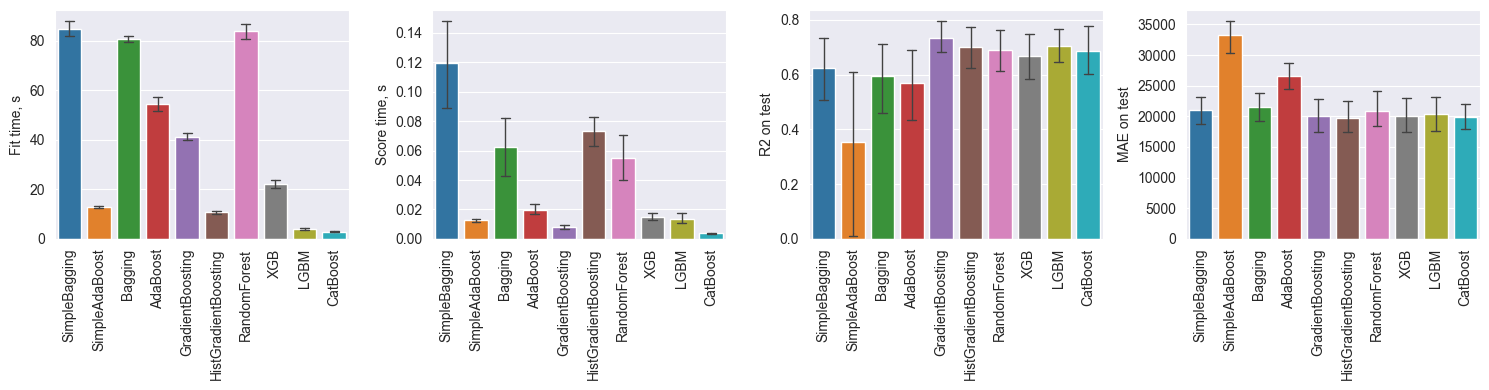

In [178]:
cv_results = pd.read_csv(PATH)
fig, axs = plt.subplots(ncols=4, figsize=(15, 4))
for y, ax in zip(["Fit time, s", "Score time, s", "R2 on test", "MAE on test"], axs.flatten()):
    sns.barplot(cv_results[["Regressor", y]], x="Regressor", y=y, errwidth=1, capsize=0.3, ax=ax)
    ax.tick_params(axis="x", rotation=90)
    ax.set_xlabel(None)
fig.tight_layout()

plt.show()

Судя по графикам, можно составить следующий список алгоритмов исходя из точности предсказаний (от лучшего показателя к худшему):
   1. Gradient Tree Boosting
   2. LightGBM
   3. Histogram-Based Gradient Boosting
   4. CatBoost
   5. Random Forest
   6. XGBoost
   7. Bagging (собственная реализация)
   8. Bagging
   9. AdaBoost
   10. AdaBoost (собственная реализация)

 При этом у первых пяти алгоритмов ошибка R2 примерно 0.75. По времени наиболее долго работали алгоритмы Bagging и RandomForest, все остальные меньше 40 секунд.